# Random Forest Model

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)



=== Uber Fare Prediction (Random Forest, Coordinates-Based) ===
RMSE: 5.02
R² Score: 0.72

=== Sample of Actual vs Predicted Fares with Coordinates (Random Forest, First 20 Rows) ===
 Pickup Latitude  Pickup Longitude  Dropoff Latitude  Dropoff Longitude  Actual Fare ($)  Predicted Fare ($)  Difference ($)
         40.7424          -74.0043           40.7482           -73.9848             7.70                7.52            0.18
         40.7254          -74.0011           40.7793           -73.9812            57.33               17.00           40.33
         40.7847          -73.9497           40.7863           -73.9527             3.30                4.95           -1.65
         40.7777          -73.9568           40.7698           -73.9666             5.00                5.13           -0.13
         40.7434          -73.9891           40.8383           -73.8572            39.00               63.42          -24.42
         40.7656          -73.9798           40.7670           -73

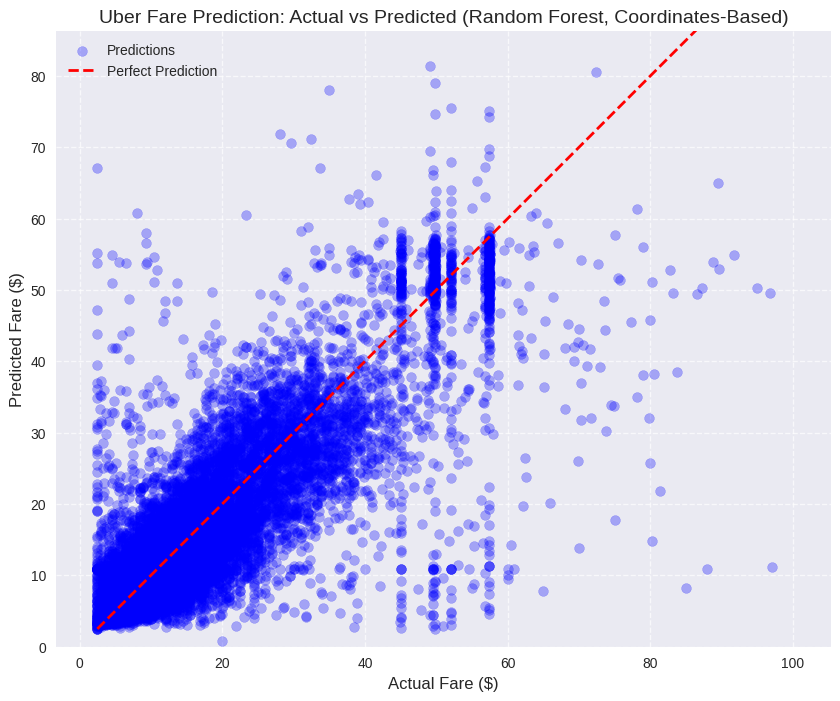


=== Feature Importance (Random Forest) ===
           Feature  Importance       Std
0         distance    1.570483  0.007449
1  passenger_count   -0.000080  0.001697

Saved: uber_fare_predictions_coordinates_rf.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Setting plot style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Haversine formula to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 0.621371  # Convert to miles

# Step 1: Loading datase
data = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')

# Step 2: Clean and preprocess data
# Remove invalid fares
data = data[data['fare_amount'].between(0, 100)]
# Remove invalid coordinates (NYC bounds: lat ~40.5 to 41.0, lon ~-74.3 to -73.7)
data = data[data['pickup_latitude'].between(40.5, 41.0) & 
            data['pickup_longitude'].between(-74.3, -73.7) &
            data['dropoff_latitude'].between(40.5, 41.0) &
            data['dropoff_longitude'].between(-74.3, -73.7)]
# Removing missing values
data = data.dropna(subset=['fare_amount', 'pickup_latitude', 'pickup_longitude', 
                          'dropoff_latitude', 'dropoff_longitude', 'passenger_count'])
# Remove duplicates
data = data.drop_duplicates()
# Filter passenger_count (1-6 is reasonable for Uber)
data = data[data['passenger_count'].between(1, 6)]

# Step 3: Feature Engineering
# Calculate distance
data['distance'] = data.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], 
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1
)
# Filter out extreme distances
data = data[data['distance'].between(0, 50)]  # Reasonable for NYC
features = ['distance', 'passenger_count']
X = data[features]
y = data['fare_amount']

# Step 4: Preprocess features
# Store indices for coordinates
X_indices = X.index
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split data
X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(
    X_scaled, y, X_indices, test_size=0.2, random_state=42
)
# Retrieve coordinates for test set
coords_test = data.loc[X_test_indices, ['pickup_latitude', 'pickup_longitude', 
                                       'dropoff_latitude', 'dropoff_longitude']]

# Step 5: Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("\n=== Uber Fare Prediction (Random Forest, Coordinates-Based) ===")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

# Step 7: Display Table
results = pd.DataFrame({
    'Pickup Latitude': coords_test['pickup_latitude'].values.round(4),
    'Pickup Longitude': coords_test['pickup_longitude'].values.round(4),
    'Dropoff Latitude': coords_test['dropoff_latitude'].values.round(4),
    'Dropoff Longitude': coords_test['dropoff_longitude'].values.round(4),
    'Actual Fare ($)': y_test.values.round(2),
    'Predicted Fare ($)': y_pred_rf.round(2),
    'Difference ($)': (y_test.values - y_pred_rf).round(2)
})
results = results.reset_index(drop=True)
print("\n=== Sample of Actual vs Predicted Fares with Coordinates (Random Forest, First 20 Rows) ===")
print(results.head(20).to_string(index=False))

# Step 8: Visualizing Predictions
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_rf, alpha=0.3, s=50, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Fare ($)', fontsize=12)
plt.ylabel('Predicted Fare ($)', fontsize=12)
plt.title('Uber Fare Prediction: Actual vs Predicted (Random Forest, Coordinates-Based)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.xlim(max(0, y_test.min() - 5), y_test.max() + 5)
plt.ylim(max(0, y_pred_rf.min() - 5), y_pred_rf.max() + 5)
plt.legend()
plt.savefig('uber_fare_predictions_coordinates_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 9: Feature Importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
feature_names = features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\n=== Feature Importance (Random Forest) ===")
print(importance_df)

# Savng Outputs
results.to_csv('uber_fare_predictions_coordinates_rf.csv', index=False)
print("\nSaved: uber_fare_predictions_coordinates_rf.csv")

# XG Boost Model

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)



=== Uber Fare Prediction (XGBoost, Coordinates-Based) ===
RMSE: 4.34
R² Score: 0.79

=== Sample of Actual vs Predicted Fares with Coordinates (XGBoost, First 20 Rows) ===
 Pickup Latitude  Pickup Longitude  Dropoff Latitude  Dropoff Longitude  Actual Fare ($)  Predicted Fare ($)  Difference ($)
         40.7424          -74.0043           40.7482           -73.9848             7.70            7.530000            0.17
         40.7254          -74.0011           40.7793           -73.9812            57.33           17.340000           39.99
         40.7847          -73.9497           40.7863           -73.9527             3.30            5.400000           -2.10
         40.7777          -73.9568           40.7698           -73.9666             5.00            6.340000           -1.34
         40.7434          -73.9891           40.8383           -73.8572            39.00           40.480000           -1.48
         40.7656          -73.9798           40.7670           -73.9867       

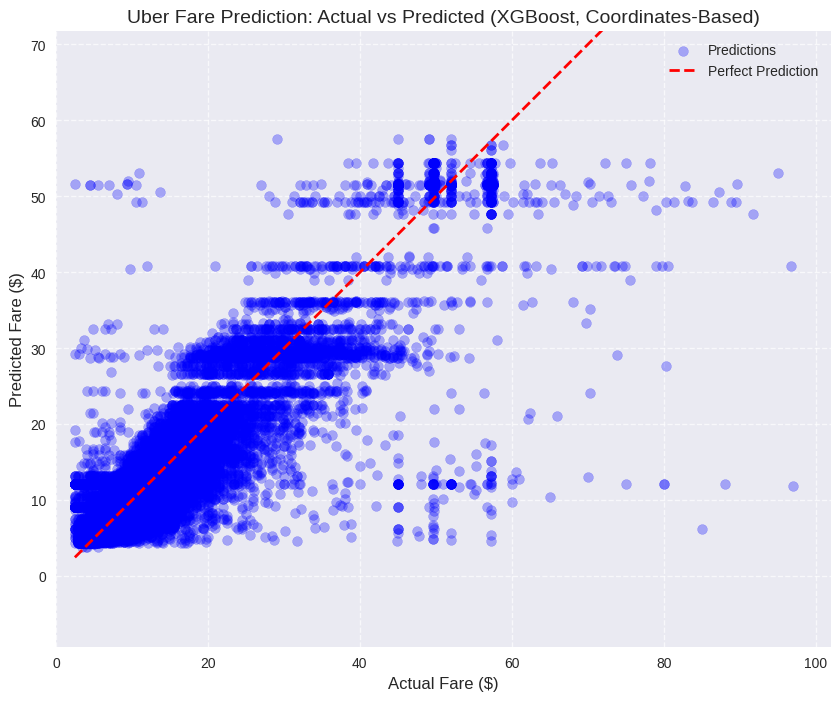


=== Feature Importance (XGBoost) ===
           Feature  Importance       Std
0         distance    1.575658  0.006729
1  passenger_count    0.001282  0.000318

Saved: uber_fare_predictions_coordinates_xgb.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Set plot style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Haversine formula to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 0.621371  # Convert to miles

# Step 1: Loading dataset
data = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')

# Step 2: Clean and preprocessing data
# Remove invalid fares
data = data[data['fare_amount'].between(0, 100)]
# Remove invalid coordinates (NYC bounds: lat ~40.5 to 41.0, lon ~-74.3 to -73.7)
data = data[data['pickup_latitude'].between(40.5, 41.0) & 
            data['pickup_longitude'].between(-74.3, -73.7) &
            data['dropoff_latitude'].between(40.5, 41.0) &
            data['dropoff_longitude'].between(-74.3, -73.7)]
# Remove missing values
data = data.dropna(subset=['fare_amount', 'pickup_latitude', 'pickup_longitude', 
                          'dropoff_latitude', 'dropoff_longitude', 'passenger_count'])
# Remove duplicates
data = data.drop_duplicates()
# Filter passenger_count (1-6 is reasonable for Uber)
data = data[data['passenger_count'].between(1, 6)]

# Step 3: Feature Engineering
# Calculate distance
data['distance'] = data.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], 
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1
)
# Filter out extreme distances
data = data[data['distance'].between(0, 50)]  # Reasonable for NYC
features = ['distance', 'passenger_count']
X = data[features]
y = data['fare_amount']

# Step 4: Preprocess features
# Store indices for coordinates
X_indices = X.index
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split data
X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(
    X_scaled, y, X_indices, test_size=0.2, random_state=42
)
# Retrieve coordinates for test set
coords_test = data.loc[X_test_indices, ['pickup_latitude', 'pickup_longitude', 
                                       'dropoff_latitude', 'dropoff_longitude']]

# Step 5: Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\n=== Uber Fare Prediction (XGBoost, Coordinates-Based) ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

# Step 7: Display Table
results = pd.DataFrame({
    'Pickup Latitude': coords_test['pickup_latitude'].values.round(4),
    'Pickup Longitude': coords_test['pickup_longitude'].values.round(4),
    'Dropoff Latitude': coords_test['dropoff_latitude'].values.round(4),
    'Dropoff Longitude': coords_test['dropoff_longitude'].values.round(4),
    'Actual Fare ($)': y_test.values.round(2),
    'Predicted Fare ($)': y_pred_xgb.round(2),
    'Difference ($)': (y_test.values - y_pred_xgb).round(2)
})
results = results.reset_index(drop=True)
print("\n=== Sample of Actual vs Predicted Fares with Coordinates (XGBoost, First 20 Rows) ===")
print(results.head(20).to_string(index=False))

# Step 8: Visualize Predictions
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, s=50, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Fare ($)', fontsize=12)
plt.ylabel('Predicted Fare ($)', fontsize=12)
plt.title('Uber Fare Prediction: Actual vs Predicted (XGBoost, Coordinates-Based)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.xlim(max(0, y_test.min() - 5), y_test.max() + 5)
plt.ylim(max(0, y_pred_xgb.min() - 5), y_pred_xgb.max() + 5)
plt.legend()
plt.savefig('uber_fare_predictions_coordinates_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 9: Feature Importance
perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
feature_names = features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\n=== Feature Importance (XGBoost) ===")
print(importance_df)

# Saving Outputs
results.to_csv('uber_fare_predictions_coordinates_xgb.csv', index=False)
print("\nSaved: uber_fare_predictions_coordinates_xgb.csv")

# Model Performance Comparison

In [4]:

comparison_df = pd.DataFrame(results)
print("\n=== Model Performance Comparison (Coordinates-Based) ===")
print(comparison_df.to_string(index=False))

# Save table
comparison_df.to_csv('uber_model_comparison.csv', index=False)
print("\nSaved: uber_model_comparison.csv")


=== Model Performance Comparison (Coordinates-Based) ===
        Model  RMSE   R²
Random Forest  4.80 0.73
      XGBoost  4.18 0.80

Saved: uber_model_comparison.csv


# Fare Prediction Of Merged Dataset

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


Uber time_stamp range (2018-adjusted): 2018-12-01 00:00:00 to 2018-12-31 23:00:00
Weather time_stamp range: 2018-11-26 03:40:44 to 2018-12-18 18:45:02

=== Uber Fare Prediction (XGBoost, Coordinates + Weather) ===
RMSE: 4.18
R² Score: 0.80

=== Sample of Actual vs Predicted Fares with Coordinates (XGBoost, First 20 Rows) ===
 Pickup Latitude  Pickup Longitude  Dropoff Latitude  Dropoff Longitude  Actual Fare ($)  Predicted Fare ($)  Difference ($)
         40.7308          -74.0015           40.7438           -74.0026             5.30            6.740000           -1.44
         40.7567          -73.9931           40.6901           -74.1779            73.00           49.610001           23.39
         40.7859          -73.9785           40.7449           -73.9897            14.50           13.920000            0.58
         40.7622          -73.9840           40.7111           -74.0102            22.10           17.389999            4.71
         40.7637          -73.9780           40.

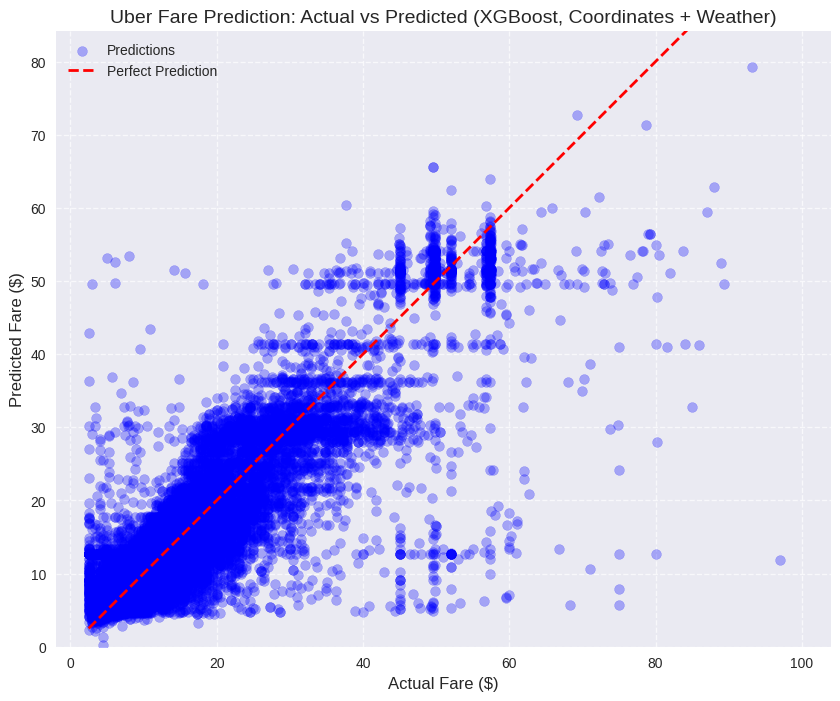


=== Feature Importance (XGBoost) ===
           Feature  Importance       Std
0         distance    1.614997  0.007338
4         pressure    0.007352  0.001002
3           clouds    0.006436  0.000941
7             wind    0.004836  0.000327
2             temp    0.004506  0.000449
1  passenger_count    0.003113  0.000591
6         humidity    0.002797  0.000441
5             rain    0.002299  0.000420

Saved: uber_fare_predictions_coordinates_weather_xgb.csv


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# Set plot style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Haversine formula to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 0.621371  # Convert to miles

# Step 1: Load datasets
try:
    uber_data = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')
    weather_data = pd.read_csv('/kaggle/input/weather-new/weather.csv')
except FileNotFoundError:
    print("Error: Ensure 'uber.csv' and 'weather.csv' are in the correct directory.")
    raise

# Step 2: Clean and preprocess data
# Uber data
uber_data = uber_data[
    (uber_data['fare_amount'].between(0, 100)) &
    (uber_data['pickup_latitude'].between(40.5, 41.0)) &
    (uber_data['pickup_longitude'].between(-74.3, -73.7)) &
    (uber_data['dropoff_latitude'].between(40.5, 41.0)) &
    (uber_data['dropoff_longitude'].between(-74.3, -73.7)) &
    (uber_data['passenger_count'].between(1, 6)) &
    (uber_data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                'dropoff_longitude', 'pickup_datetime', 'fare_amount']].notna().all(axis=1))
].drop_duplicates()

# Weather data
weather_data['rain'] = weather_data['rain'].fillna(0)
weather_data = weather_data.dropna(subset=['time_stamp'])
weather_data['time_stamp'] = weather_data['time_stamp'].astype(int)

# Aggregate weather data by time_stamp (average across locations)
weather_agg = weather_data.groupby('time_stamp')[
    ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']
].mean().reset_index()

# Step 3: Feature Engineering
# Calculate distance
uber_data['distance'] = uber_data.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                          row['dropoff_latitude'], row['dropoff_longitude']), axis=1
)
uber_data = uber_data[uber_data['distance'].between(0, 50)]

# Convert pickup_datetime to Unix timestamp (nearest hour)
uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'], errors='coerce')
uber_data = uber_data.dropna(subset=['pickup_datetime'])

# Simulate 2018 timestamps to align with weather.csv (adjust if needed)
uber_data['time_stamp'] = uber_data['pickup_datetime'].apply(
    lambda x: int(pd.Timestamp(year=2018, month=12, day=x.day, hour=x.hour).timestamp())
)

# Step 4: Merge datasets
# Round timestamps to nearest hour for merging
uber_data['time_stamp_hour'] = (uber_data['time_stamp'] // 3600 * 3600).astype(int)
weather_agg['time_stamp_hour'] = (weather_agg['time_stamp'] // 3600 * 3600).astype(int)

# Merge on rounded timestamp
merged_data = uber_data.merge(
    weather_agg.drop(columns='time_stamp'),
    left_on='time_stamp_hour',
    right_on='time_stamp_hour',
    how='left'
)

# Check if merged_data is empty
if merged_data.empty:
    print("Error: Merged dataset is empty. Check timestamp compatibility.")
    raise ValueError("Empty merged dataset.")

# Handle missing weather data
weather_cols = ['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']
for col in weather_cols:
    merged_data[col] = merged_data[col].fillna(merged_data[col].mean())

# Diagnostic: Timestamp overlap
print("Uber time_stamp range (2018-adjusted):",
      pd.to_datetime(uber_data['time_stamp'], unit='s').min(), "to",
      pd.to_datetime(uber_data['time_stamp'], unit='s').max())
print("Weather time_stamp range:",
      pd.to_datetime(weather_agg['time_stamp'], unit='s').min(), "to",
      pd.to_datetime(weather_agg['time_stamp'], unit='s').max())

# Step 5: Prepare features and target
features = ['distance', 'passenger_count', 'temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']
X = merged_data[features]
y = merged_data['fare_amount']

# Store indices for coordinates
X_indices = X.index
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test, X_train_indices, X_test_indices = train_test_split(
    X_scaled, y, X_indices, test_size=0.2, random_state=42
)

# Retrieve coordinates for test set
coords_test = merged_data.loc[X_test_indices, ['pickup_latitude', 'pickup_longitude',
                                              'dropoff_latitude', 'dropoff_longitude']]

# Step 6: Train XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 7: Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print("\n=== Uber Fare Prediction (XGBoost, Coordinates + Weather) ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")

# Step 8: Display Table
results = pd.DataFrame({
    'Pickup Latitude': coords_test['pickup_latitude'].values.round(4),
    'Pickup Longitude': coords_test['pickup_longitude'].values.round(4),
    'Dropoff Latitude': coords_test['dropoff_latitude'].values.round(4),
    'Dropoff Longitude': coords_test['dropoff_longitude'].values.round(4),
    'Actual Fare ($)': y_test.values.round(2),
    'Predicted Fare ($)': y_pred_xgb.round(2),
    'Difference ($)': (y_test.values - y_pred_xgb).round(2)
})
results = results.reset_index(drop=True)
print("\n=== Sample of Actual vs Predicted Fares with Coordinates (XGBoost, First 20 Rows) ===")
print(results.head(20).to_string(index=False))

# Step 9: Visualize Predictions
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, s=50, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Fare ($)', fontsize=12)
plt.ylabel('Predicted Fare ($)', fontsize=12)
plt.title('Uber Fare Prediction: Actual vs Predicted (XGBoost, Coordinates + Weather)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')
plt.xlim(max(0, y_test.min() - 5), y_test.max() + 5)
plt.ylim(max(0, y_pred_xgb.min() - 5), y_pred_xgb.max() + 5)
plt.legend()
plt.savefig('uber_fare_predictions_coordinates_weather_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 10: Feature Importance
perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\n=== Feature Importance (XGBoost) ===")
print(importance_df)

# Step 11: Save Outputs
results.to_csv('uber_fare_predictions_coordinates_weather_xgb.csv', index=False)
print("\nSaved: uber_fare_predictions_coordinates_weather_xgb.csv")


# Predict Fare (Input coordinates and Date, Time)

In [4]:

def predict_uber_fare(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon, date_time_str, passenger_count=1):
    """
    Predict Uber fare for given coordinates, time, and passenger count.
    
    Parameters:
    - pickup_lat, pickup_lon: float, pickup coordinates
    - dropoff_lat, dropoff_lon: float, dropoff coordinates
    - date_time_str: str, e.g., '2018-12-01 14:30:00'
    - passenger_count: int, number of passengers (default 1)
    
    Returns:
    - Predicted fare in dollars (rounded to 2 decimal places)
    """
    # Validate coordinates
    if not (40.5 <= pickup_lat <= 41.0 and -74.3 <= pickup_lon <= -73.7 and
            40.5 <= dropoff_lat <= 41.0 and -74.3 <= dropoff_lon <= -73.7):
        print("Error: Coordinates outside NYC bounds (lat: 40.5–41.0, lon: -74.3–-73.7).")
        return None
    
    # Calculate distance
    distance = haversine(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon)
    if not 0 < distance <= 50:
        print("Error: Invalid distance (must be 0–50 miles).")
        return None
    
    # Parse date/time
    try:
        dt = pd.to_datetime(date_time_str)
        time_stamp = int(dt.timestamp())
        time_stamp_hour = (time_stamp // 3600 * 3600)
    except ValueError:
        print("Error: Invalid date format. Use 'YYYY-MM-DD HH:MM:SS'.")
        return None
    
    # Get weather data for the timestamp
    weather_subset = weather_agg[weather_agg['time_stamp_hour'] == time_stamp_hour]
    if weather_subset.empty:
        # Use mean weather values if no match
        weather_vals = weather_agg[weather_cols].mean().to_dict()
    else:
        weather_vals = weather_subset.iloc[0][weather_cols].to_dict()
    
    # Prepare input features
    input_data = pd.DataFrame({
        'distance': [distance],
        'passenger_count': [passenger_count],
        'temp': [weather_vals['temp']],
        'clouds': [weather_vals['clouds']],
        'pressure': [weather_vals['pressure']],
        'rain': [weather_vals['rain']],
        'humidity': [weather_vals['humidity']],
        'wind': [weather_vals['wind']]
    })
    
    # Scale features
    input_scaled = scaler.transform(input_data)
    
    # Predict fare
    fare = xgb_model.predict(input_scaled)[0]
    return round(fare, 2)

# Example usage
example_fare = predict_uber_fare(
    pickup_lat=40.7500, pickup_lon=-73.9900,  # Midtown Manhattan
    dropoff_lat=40.7700, dropoff_lon=-73.9600,  # Upper East Side
    date_time_str='2018-12-01 14:30:00',
    passenger_count=1
)
print(f"Predicted Fare: ${example_fare}")


Predicted Fare: $11.550000190734863


# User Input Feature

In [8]:

def get_user_input_and_predict():
    """
    Prompt user for input and predict Uber fare using predict_uber_fare, without validating coordinates.
    Runs in a loop until the user chooses to exit.
    """
    while True:
        print("\n=== Uber Fare Prediction ===")
        try:
            # Get coordinates (no validation)
            pickup_lat = float(input("Enter pickup latitude: "))
            pickup_lon = float(input("Enter pickup longitude: "))
            dropoff_lat = float(input("Enter dropoff latitude: "))
            dropoff_lon = float(input("Enter dropoff longitude: "))
            
            # Get date/time
            date_time_str = input("Enter date and time (YYYY-MM-DD HH:MM:SS, e.g., 2018-12-01 14:30:00): ")
            
            # Get passenger count
            passenger_count = int(input("Enter passenger count (1–6): "))
            
            # Validate passenger count
            if not 1 <= passenger_count <= 6:
                print("Error: Passenger count must be between 1 and 6.")
                continue
            
            # Predict fare
            fare = predict_uber_fare(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon,
                                     date_time_str, passenger_count)
            
            if fare is not None:
                print(f"\nPredicted Fare: ${fare}")
            
        except ValueError as e:
            print(f"Error: Invalid input. Ensure coordinates and passenger count are numbers, "
                  f"and date is in 'YYYY-MM-DD HH:MM:SS' format. ({e})")
        
        # Ask if user wants to continue
        retry = input("\nWould you like to predict another fare? (yes/no): ").strip().lower()
        if retry != 'yes':
            print("Exiting fare prediction.")
            break

# Run the user input function
get_user_input_and_predict()



=== Uber Fare Prediction ===


Enter pickup latitude:  40.728225
Enter pickup longitude:  -73.994355
Enter dropoff latitude:  40.750325
Enter dropoff longitude:  40.728225
Enter date and time (YYYY-MM-DD HH:MM:SS, e.g., 2018-12-01 14:30:00):  2009-07-17 20:04:56
Enter passenger count (1–6):  1


Error: Coordinates outside NYC bounds (lat: 40.5–41.0, lon: -74.3–-73.7).



Would you like to predict another fare? (yes/no):  40.728225


Exiting fare prediction.


# Highest Trip Generation Probablity

In [10]:

from sklearn.cluster import KMeans

def find_high_trip_generation_locations(top_n=5, use_clustering=False, grid_resolution=0.01):
  
    # Round coordinates to create a grid
    uber_data['lat_grid'] = uber_data['pickup_latitude'].round(np.log10(1/grid_resolution).astype(int))
    uber_data['lon_grid'] = uber_data['pickup_longitude'].round(np.log10(1/grid_resolution).astype(int))
    
    # Count trips per grid cell
    trip_counts = uber_data.groupby(['lat_grid', 'lon_grid']).size().reset_index(name='trip_count')
    
    if use_clustering:
        # Apply K-Means clustering to identify high-demand areas
        coords = trip_counts[['lat_grid', 'lon_grid']]
        kmeans = KMeans(n_clusters=min(10, len(coords)), random_state=42)
        trip_counts['cluster'] = kmeans.fit_predict(coords)
        
        # Get centroid of each cluster and sum trip counts
        cluster_data = trip_counts.groupby('cluster').agg({
            'lat_grid': 'mean',
            'lon_grid': 'mean',
            'trip_count': 'sum'
        }).reset_index()
        
        # Sort by trip count
        top_locations = cluster_data.sort_values('trip_count', ascending=False).head(top_n)
    else:
        # Sort by trip count without clustering
        top_locations = trip_counts.sort_values('trip_count', ascending=False).head(top_n)
    
    print(f"\n=== Top {top_n} Locations with Highest Trip Generation ===")
    print(top_locations[['lat_grid', 'lon_grid', 'trip_count']].to_string(index=False))
    
    return top_locations

def predict_fare_at_high_demand_locations(top_locations, dropoff_lat, dropoff_lon, date_time_str, passenger_count=1):
    """
    Predict fares for trips starting at high-demand locations to a specified dropoff point.
    
    Parameters:
    - top_locations: DataFrame, output from find_high_trip_generation_locations
    - dropoff_lat, dropoff_lon: float, dropoff coordinates
    - date_time_str: str, e.g., '2018-12-01 14:30:00'
    - passenger_count: int, number of passengers (default 1)
    """
    print("\n=== Fare Predictions from High-Demand Pickup Locations ===")
    for _, row in top_locations.iterrows():
        pickup_lat = row['lat_grid']
        pickup_lon = row['lon_grid']
        fare = predict_uber_fare(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon,
                                 date_time_str, passenger_count)
        if fare is not None:
            print(f"Pickup: ({pickup_lat}, {pickup_lon}), Trip Count: {row['trip_count']}, "
                  f"Predicted Fare: ${fare}")

# Example usage with user input
def get_user_input_for_high_demand_fare():
    """
    Prompt user for dropoff coordinates, date/time, and passenger count to predict fares
    from high-demand pickup locations.
    """
    try:
        print("\n=== Predict Fares from High-Demand Locations ===")
        dropoff_lat = float(input("Enter dropoff latitude: "))
        dropoff_lon = float(input("Enter dropoff longitude: "))
        date_time_str = input("Enter date and time (YYYY-MM-DD HH:MM:SS, e.g., 2018-12-01 14:30:00): ")
        passenger_count = int(input("Enter passenger count (1–6): "))
        
        if not 1 <= passenger_count <= 6:
            print("Error: Passenger count must be between 1 and 6.")
            return
        
        # Find top high-demand locations
        top_locations = find_high_trip_generation_locations(top_n=5, use_clustering=False)
        
        # Predict fares from these locations
        predict_fare_at_high_demand_locations(top_locations, dropoff_lat, dropoff_lon,
                                              date_time_str, passenger_count)
        
    except ValueError as e:
        print(f"Error: Invalid input. Ensure coordinates and passenger count are numbers, "
              f"and date is in 'YYYY-MM-DD HH:MM:SS' format. ({e})")

# Run the function
get_user_input_for_high_demand_fare()



=== Predict Fares from High-Demand Locations ===


Enter dropoff latitude:  40.809783
Enter dropoff longitude:  -73.963971
Enter date and time (YYYY-MM-DD HH:MM:SS, e.g., 2018-12-01 14:30:00):  2018-12-01 14:30:00
Enter passenger count (1–6):  2



=== Top 5 Locations with Highest Trip Generation ===
 lat_grid  lon_grid  trip_count
    40.76    -73.97       12019
    40.75    -73.99       11079
    40.76    -73.98       10338
    40.75    -73.98        9736
    40.74    -73.99        8870

=== Fare Predictions from High-Demand Pickup Locations ===
Pickup: (40.76, -73.97), Trip Count: 12019.0, Predicted Fare: $15.930000305175781
Pickup: (40.75, -73.99), Trip Count: 11079.0, Predicted Fare: $19.889999389648438
Pickup: (40.76, -73.98), Trip Count: 10338.0, Predicted Fare: $16.440000534057617
Pickup: (40.75, -73.98), Trip Count: 9736.0, Predicted Fare: $19.440000534057617
Pickup: (40.74, -73.99), Trip Count: 8870.0, Predicted Fare: $23.1200008392334
